<a href="https://colab.research.google.com/github/WerberAlex/E-DOLLYV2/blob/main/Chapter04/CNN_on_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torchvision import datasets
import torch
data_folder = '/content/' # This can be any directory you want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 177kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.21MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 16.9MB/s]


In [2]:
tr_images = fmnist.data
tr_targets = fmnist.targets

In [3]:
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,1,28,28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=5),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=5),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(2048, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()


In [6]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

In [7]:
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [8]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [9]:
!pip install torch_summary
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 24, 24]          1,664
├─MaxPool2d: 1-2                         [-1, 64, 12, 12]          --
├─ReLU: 1-3                              [-1, 64, 12, 12]          --
├─Conv2d: 1-4                            [-1, 128, 8, 8]           204,928
├─MaxPool2d: 1-5                         [-1, 128, 4, 4]           --
├─ReLU: 1-6                              [-1, 128, 4, 4]           --
├─Flatten: 1-7                           [-1, 2048]                --
├─Linear: 1-8                            [-1, 256]                 524,544
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 733,706
Trainable params: 733,706
Non-trainable params: 0
Total mult-adds (M): 14.56
Input size (MB): 0.00
Forward/backward pass size (MB): 0.35
Params size (MB): 2.80
Estimated Total Size (MB): 

In [10]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


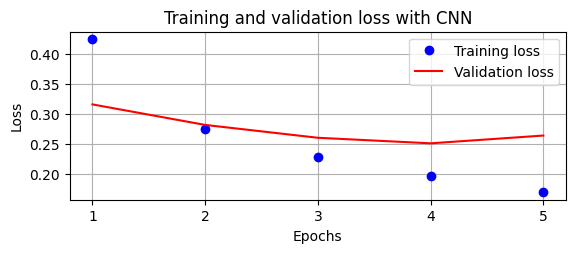

/tmp/ipython-input-2406712320.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


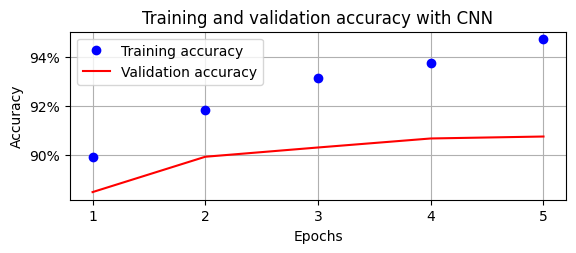

In [11]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

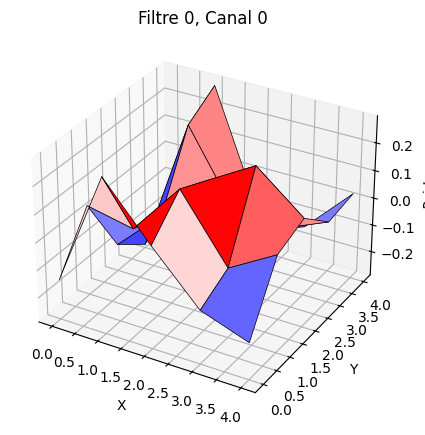

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # nécessaire pour 3D
import numpy as np
import torch

def plot_conv_filter_3d(conv_layer, filter_index=0, channel_index=0):
    """
    Affiche un filtre convolutionnel en 3D.

    conv_layer : nn.Conv2d
    filter_index : numéro du filtre à afficher (0 ≤ filter_index < out_channels)
    channel_index : canal du filtre à afficher (0 ≤ channel_index < in_channels)
    """
    W = conv_layer.weight.data.cpu().numpy()
    filter_weights = W[filter_index, channel_index]  # shape (kernel_h, kernel_w)

    h, w = filter_weights.shape
    X, Y = np.meshgrid(np.arange(w), np.arange(h))
    Z = filter_weights

    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='bwr', edgecolor='k', linewidth=0.5)
    ax.set_title(f'Filtre {filter_index}, Canal {channel_index}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Poids')
    plt.show()

conv_layers = [m for m in model.modules() if isinstance(m, torch.nn.Conv2d)]
# Par exemple, la 2ème couche Conv2d
conv_layer = conv_layers[0]

plot_conv_filter_3d(conv_layer, filter_index=0, channel_index=0)  # affiche le premier filtre du canal 0


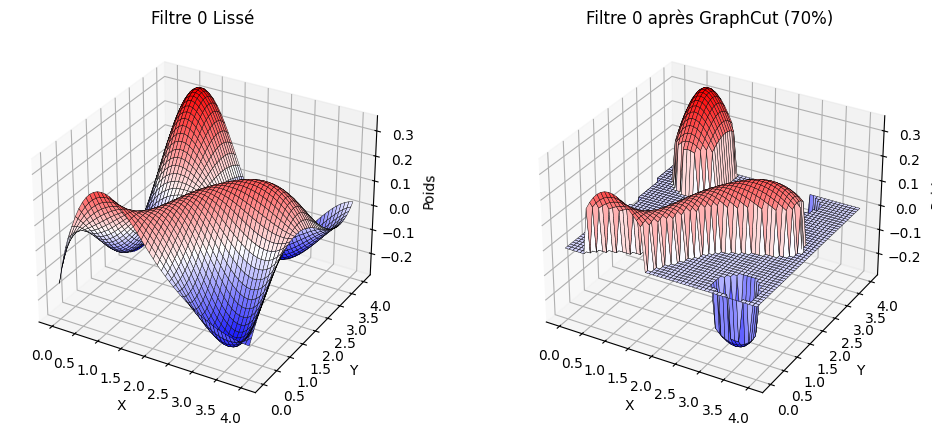

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch
from scipy.interpolate import RegularGridInterpolator

def graphcut_filter_surface(Zsmooth, percentile=70):
    """
    Simule un GraphCut sur une surface lisse en utilisant un seuil basé sur percentile.
    Zsmooth : surface lissée (2D numpy array)
    percentile : pourcentage de poids à conserver
    """
    threshold = np.percentile(np.abs(Zsmooth), percentile)
    mask = np.abs(Zsmooth) >= threshold
    Zcut = Zsmooth * mask
    return Zcut, mask

def plot_conv_surface_with_graphcut(conv_layer, filter_index=0, channel_index=0, smooth_factor=50, percentile=70):
    W = conv_layer.weight.data.cpu().numpy()
    filter_weights = W[filter_index, channel_index]

    h, w = filter_weights.shape
    y = np.arange(h)
    x = np.arange(w)

    # Interpolation lisse
    interp_func = RegularGridInterpolator((y, x), filter_weights, method='cubic')
    ynew = np.linspace(0, h-1, smooth_factor)
    xnew = np.linspace(0, w-1, smooth_factor)
    X, Y = np.meshgrid(xnew, ynew)
    points = np.array([Y.ravel(), X.ravel()]).T
    Zsmooth = interp_func(points).reshape(smooth_factor, smooth_factor)

    # GraphCut simplifié
    Zcut, mask = graphcut_filter_surface(Zsmooth, percentile=percentile)

    # Affichage 3D
    fig = plt.figure(figsize=(12,5))

    # Surface lisse
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot_surface(X, Y, Zsmooth, cmap='bwr', edgecolor='k', linewidth=0.3)
    ax1.set_title(f'Filtre {filter_index} Lissé')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Poids')

    # Surface après GraphCut
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(X, Y, Zcut, cmap='bwr', edgecolor='k', linewidth=0.3)
    ax2.set_title(f'Filtre {filter_index} après GraphCut ({percentile}%)')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Poids')

    plt.show()
    return Zcut, mask

# Exemple d'utilisation
conv_layers = [m for m in model.modules() if isinstance(m, torch.nn.Conv2d)]
# Par exemple, la 2ème couche Conv2d
conv_layer = conv_layers[0]

Zcut, mask = plot_conv_surface_with_graphcut(conv_layer, filter_index=0, channel_index=0, smooth_factor=50, percentile=70)


In [28]:
import numpy as np

def project_graphcut_to_kernel_values(Zcut, mask, kernel_size=5, method='extreme'):
    """
    Projette une surface Zcut + mask sur une grille kernel_size x kernel_size
    en gardant la valeur la plus importante (positive ou négative) des zones conservées dans chaque bloc.

    Zcut : surface lissée après GraphCut (2D numpy array)
    mask : masque booléen correspondant aux zones conservées (même taille que Zcut)
    kernel_size : taille de la grille cible (ex: 5 pour 5x5)
    method : 'extreme' ou 'mean'
        - 'extreme' : prend la valeur avec le plus grand module (positif ou négatif)
        - 'mean' : moyenne des valeurs non nulles

    Retour : kernel_values 5x5 avec 0 pour les zones à supprimer et valeur projetée ailleurs
    """
    assert Zcut.shape == mask.shape, "Zcut et mask doivent avoir la même taille"

    h_smooth, w_smooth = Zcut.shape
    block_h = h_smooth // kernel_size
    block_w = w_smooth // kernel_size
    kernel_values = np.zeros((kernel_size, kernel_size))

    for i in range(kernel_size):
        for j in range(kernel_size):
            block = Zcut[i*block_h:(i+1)*block_h, j*block_w:(j+1)*block_w]
            block_mask = mask[i*block_h:(i+1)*block_h, j*block_w:(j+1)*block_w]
            block_filtered = block * block_mask  # met à zéro les zones faibles

            values = block_filtered[block_filtered != 0]
            if len(values) == 0:
                kernel_values[i,j] = 0
            else:
                if method == 'extreme':
                    # valeur avec le plus grand module (conserve le signe)
                    kernel_values[i,j] = values[np.argmax(np.abs(values))]
                elif method == 'mean':
                    kernel_values[i,j] = np.mean(values)
                else:
                    raise ValueError("method doit être 'extreme' ou 'mean'")

    return kernel_values


In [29]:
# Zcut et mask obtenus après GraphCut
kernel_values_5x5 = project_graphcut_to_kernel_values(Zcut, mask, kernel_size=5, method='max')
print("Kernel 5x5 avec valeurs projetées :\n", kernel_values_5x5)


Kernel 5x5 avec valeurs projetées :
 [[ 0.25177984  0.27224437  0.18908196 -0.          0.        ]
 [-0.          0.          0.21175733  0.21054961  0.        ]
 [ 0.          0.          0.21627574  0.2417548   0.23598712]
 [ 0.26695459  0.27336827 -0.         -0.         -0.        ]
 [ 0.34526416  0.34676726  0.         -0.          0.        ]]


In [30]:
import matplotlib.pyplot as plt
import numpy as np

def show_filter(matrix_5, title="Filtre 2D"):
    """
    Affiche une matrice 5x5 (ou n×n) en 2D avec une colormap rouge/bleu.
    """
    plt.figure(figsize=(4,4))
    plt.imshow(matrix_5, cmap='bwr', interpolation='nearest')
    plt.colorbar(label='Poids')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()


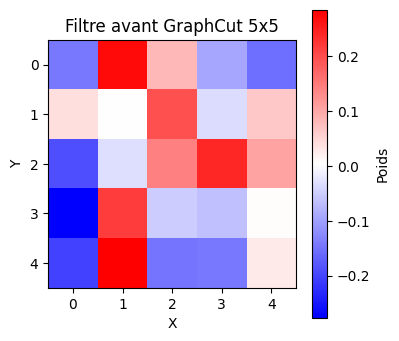

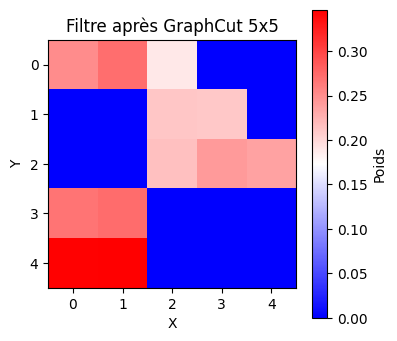

In [32]:
# matrix_5 : ton kernel 5x5 après GraphCut
conv_layers = [m for m in model.modules() if isinstance(m, torch.nn.Conv2d)]
# Par exemple, la 2ème couche Conv2d
conv_layer = conv_layers[0]
W = conv_layer.weight.data.cpu().numpy()
filter_weights = W[0,0]
matrix_5 = filter_weights
show_filter(matrix_5, title="Filtre avant GraphCut 5x5")
show_filter(kernel_values_5x5, title="Filtre après GraphCut 5x5")